In [29]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack


# Just for in this notebook
import sys
sys.path.append('../assignment1/to_hand_in/')

import some_routines as sr
from tqdm import tqdm_notebook as tqdm

In [30]:
def romberg(func, lbound, ubound, order=6, relacc=1e-14):
    """
    Calculate the integral of a function using Romberg's method
    with equal spaced abscissae
    
    func   -- function which gives the y values
    lbound -- lower bound of integral
    ubound -- upper bound of integral
    order  -- Amount of steps combining trapezoids, 
    		  final step will have 2**order intervals
    relacc -- target relative accuracy
    
    Returns 
    Value of the integral
    Error estimates at every step
     
    The error estimate is given as the difference between last 2 orders
    """
    
    # for saving the relative error
    relerror = [] # one value per column of the Romberg table
    # for saving S_i,j's
    all_S = np.zeros((order,order))
    
    i = 0
    delta_x = (ubound-lbound)
    points = sr.linspace(lbound,ubound,2**i+1)
    integral = delta_x/2 * np.sum(func(points))
    all_S[0,0] = integral
    
    # Calculate the first column (S_{i,0})
    for i in range(1,order):
        delta_x /= 2
        # add points in the middle
        points = sr.linspace(lbound,ubound,2**i+1)
        # add new points to the integral (use slicing to alternate)
        integral = 0.5*integral + delta_x * np.sum(func(points[1::2]))
        
        all_S[i,0] = integral
    
    # Calculate all others by combining
    for j in range(1,order): # column of Romberg table
        for i in range(j,order): # row of Romberg table
            all_S[i,j] = (4**j*all_S[i,j-1] - all_S[i-1,j-1]) / (
                           4**j - 1)
        # Relative error estimate is difference between last 
        # two estimates divided by the estimate 
        relerror.append(np.abs(1 - all_S[i,j-1]/all_S[i,j]) )
        if relerror[-1] < relacc:
#             print (f"Target relative error of {relacc} reached at S_{i,j}")
            # Target error reached, can stop
            return all_S[i,j], relerror
        
        if len(relerror) > 2:
            if relerror[-1] > relerror[-2]:
#                 print (f"Error increased at at S_{i,j}")
                # error increased, should stop
                return all_S[i,j,:],relerror        
    
    return all_S[order-1,order-1], relerror

# 4. Zeldovich approximation.

#### In this part we will set up the initial conditions using something called the Zeldovich approximation. The Zeldovich approximation is a first order linear Lagrangian structure formation model that can be used to set up initial conditions for a cosmological simulation. In its simplest form the Zeldovich approximation is given by 

$$ {\bf x}(t) = {\bf q} + D(t) {\bf S}({\bf q})$$

#### At first this may look complicated, but this equation can basically be described as ${\bf x}(t) = {\bf x_0} + {\bf v}t$ with constant ${\bf v}$.  This means that ${\bf q}$ is the initial position of a matter particle, ${\bf x}(t)$ is the position at time $t$, $D(t)$ is the linear growth function and ${\bf S}({\bf q})$ is a time independent displacement vector. In this exercise we will use the scale factor $a$, redshift $z$ and time interchangeable as time variable. 



#### Then a lot of formulas which I wont repeat here. 

#### During this exercise we will assume periodic boundary conditions. This means that when a particle moves outside of the simulation box it should enter through the other side of the box

#### a) Calculate the growth factor at z=50 numerically with a relative accuracy of $10^-5$. 

The growth factor in terms of z is given by
\begin{equation}
D(z) = \frac{5\Omega_m H_0^2}{2} H(z) \int_z^\infty \frac{1+z'}{H^3(z')} dz'.
\end{equation}

With $a = 1/(1+z)$ we have 
\begin{equation}
\frac{dz}{da} = -1/a^2
\end{equation}

Switching coordinates to $a$ thus gives us the following integral:
\begin{equation}
D(a) = \frac{5\Omega_m H_0^2}{2} H(z=1/a-1) \int_0^{a} \frac{1}{a'^{3} H^3(z'=1/a'-1)} da'.
\end{equation}
Where the integral bounds have switched due to the negative sign of the Jacobian. 

With 
\begin{equation}
H(z)^2 = H_0^2 \left(\Omega_m(1+z)^3+\Omega_\Lambda \right),
\end{equation}
we can rewrite this as
\begin{equation}
D(a) = \frac{5\Omega_m H_0^3}{2} \sqrt{\Omega_m a^{-3}+\Omega_\Lambda} \int_0^{1/(1+z)} \frac{1}{a'^{3} H_0^3 \left(\Omega_m a'^{-3} +\Omega_\Lambda\right)^{3/2}} da.
\end{equation}
From which we see that the Hubble constant at $z=0$ drops out. Simplifying the integral, we get
\begin{equation}
D(a) = \frac{5\Omega_m}{2} \sqrt{\Omega_m a^{-3}+\Omega_\Lambda} \int_0^{1/(1+z)} \frac{1}{\left(\Omega_m a'^{-1} +\Omega_\Lambda a'^2 \right)^{3/2}} da.
\end{equation}
Since the function has an integrable singularity at the limit $a=0$ we can use extended midpoint Romberg integration to integrate this function. However, it is simpler to simply evaluate the limit
\begin{equation}
\begin{split}
\lim_{a \to 0} \left( \frac{1}{\Omega_m a^{-1} + \Omega_\Lambda a^2} \right) = \\
\lim_{a \to 0} \left( \frac{1}{\Omega_m a^{-1}} \right) = \\
\lim_{a \to 0} \left( \frac{a}{\Omega_m} \right) = 0
\end{split}
\end{equation}
Thus we can simply set the function to 0 whenever we evaluate the function inside the integral at $a=0$


In [31]:
def Hubbleparam(z, Omega_m, Omega_Lamb):
    """
    Return the Hubble parameter H(z) in terms of H0
    given current cosmological constants 
    """
    return np.sqrt(Omega_m*(1+z)**3+Omega_Lamb)

In [32]:
def integrand(a, Omega_m, Omega_Lamb):
    """
    Return the function inside the integral as a function of a
    """
    # The integrand goes to 0 for a=0, 
    # but python does not like division by zero    
    where0 = a == 0
    a[where0] = 1e10 # Put zeroes temporarily on some large number   
    ans = 1/(Omega_m/a + Omega_Lamb*a**2)**(3/2)
    ans[where0] = 0 # Make sure the function is 0 for a=0
    return ans
    

In [122]:
def growth_factor(a, Omega_m, Omega_Lamb):
    """
    Return the growth factor at given scale factor.
    Uses the functions Hubbleparam() and integrand()
    """
    # Transform from a to z
    z = 1/a - 1
    
    # Function that will be integrated over a
    to_integ = lambda a: integrand(a, Omega_m, Omega_Lamb)

    Dz = 5*Omega_m/2 * Hubbleparam(z,Omega_m,Omega_Lamb)
    # save integ seperately, needed for b)
    integ = romberg(to_integ,0,a,order=6,relacc=1e-5)[0]
    Dz *= integ
    
    return Dz, integ
    
Omega_m, Omega_Lamb = 0.3, 0.7
z = 50
a = 1/(1+z)
# Calculate growth factor at z=50
Dz, integ = growth_factor(a, Omega_m, Omega_Lamb)
print ("Growth factor at z=50:", Dz)

Growth factor at z=50: 0.019607862559909386


In [125]:
# This is the value of the integral only, needed for b
H0 = 70 # km/s/Mpc
I = integ/H0**3

3.8208075172174565e-10


#### b) We also want to calculate the derivative at z=50 in order to be able to calculate the momentum of the particles. In order to calculate the time derivative of the linear growth factor it is important to realize that we cannot easily calculate it directly, but need to calculate it indirectly as $$ \dot{D}(t) = \frac{dD}{da} \dot{a},$$
#### in which we know that $\dot{a}(z) = H(z)a(z)$. Calculate the derivative analytically, and give its value at z=50. Bonus point if you also numerically match the analytical result within $10^{-8}$

We start with 
\begin{equation}
\begin{split}
\frac{dD}{da} = \frac{d}{da} \left( \frac{5\Omega_m H_0^2}{2} H(a) \int_0^{a} \frac{1}{a'^{3} H^3(a')} da' \right) \\ 
= \frac{5\Omega_m H_0^2}{2} \left(I \frac{dH}{da} + H(z) \frac{d}{da} \int_0^{a} \frac{1}{a'^{3} H^3(a')} da' \right)
\end{split}
\end{equation}
where $I$ now denotes the numerical value of the integral that we have used to numerically calculate the growth factor in question 4a). The derivative of the Hubble parameter is given by
\begin{equation}
\begin{split}
\frac{dH}{da} = \frac{d}{da} \left(H_0 \sqrt{\Omega_m a^{-3} + \Omega_\Lambda} \right) \\
=  \frac{-3\Omega_mH_0}{2a^4\sqrt{\Omega_m a^{-3}+\Omega_\Lambda}}
\end{split}
\end{equation}
The derivative of the integral is simply the function inside the integral evaluated at the bounds. Since we have already shown this function goes to 0 for $a=0$ this results in
\begin{equation}
\frac{d}{da} \int_0^{a} \frac{1}{a'^{3} H^3(a')} da' = \frac{1}{a^{3} H^3(a)}
\end{equation}

Thus the full (semi-) analytical expression for $dD/da$ is given by
\begin{equation}
\frac{5\Omega_m H_0^2}{2} \left(I \frac{-3\Omega_mH_0}{2a^4\sqrt{\Omega_m a^{-3}+\Omega_\Lambda}} + \frac{1}{a^{3} H^2(a)} \right)
\end{equation}
Factoring out some common terms gives
\begin{equation}
\frac{dD}{da} = \frac{5\Omega_m H_0^2}{2a^3 H(a)} \left( \frac{-3\Omega_m H_0^2 I}{2a} + \frac{1}{a H(a)} \right)
\end{equation}
Multiplying by $\dot{a} = H(a)a$ gives
\begin{equation}
\frac{dD}{dt} = \frac{5\Omega_m H_0^2}{2a^3 H(a)} \left( \frac{-3\Omega_m I H_0^2  H(a)}{2} + 1 \right)
\end{equation}
Finally, plugging in the values of the cosmological constants, the value of the numerical integral and $a=1/51$ we get

In [142]:
def deriv_H(a, Omega_m, Omega_Lamb):
    """Not used"""
    ans = -3*Omega_m*a**(-4)*H0
    ans /= 2*np.sqrt(Omega_m*a**(-3)+Omega_Lamb)
    
    return ans

def analytical_deriv(z):
    """return analytical derivative at z=z"""
    a = 1/(1+z)
    if z == 50: # use earlier computed result
        Inum = I
    else:
        # use Romberg
        to_integ = lambda a: integrand(a, Omega_m, Omega_Lamb)
        integ = romberg(to_integ,0,a,order=6,relacc=1e-5)[0]
        Inum = integ/H0**3
        
    ans = 5*Omega_m*H0**2/(2*a**3*H0
                           *Hubbleparam(z, Omega_m, Omega_Lamb))
    ans *= (-3*Omega_m*Inum*H0**3*Hubbleparam(z,Omega_m,Omega_Lamb)/2 + 1)

    return ans

In [145]:
anderiv = analytical_deriv(z=50)
print (f"Analytical derivative at z=50: {anderiv}")

# a = 0.0025
# z = 1/a - 1
# anderiv = analytical_deriv(z)
# print (f"Analytical derivative at z={z}: {anderiv}")

Analytical derivative at z=50: 34499.31530106616


#### c) Use the Zeldovich approximation to generate a movie of the evolution of a volume in two dimensions from a scale factor of 0.0025 until a scale factor of 1.0. Use 64x64 particles in a square grid. Your movie should contain at least 30 frames per seconds and should at least last 3 seconds. Also plot the position and momentum of the first 10 particles along the y-direction vs a.

So. 
First generate the $c_k$ space , then IFFT this (as function of q) to calculate the S(q). 

Then, all initial particle positions have vector q given by their grid coordinate (indices). All particles will have some constant over time vector S(q) that will point them to where they have to evolve. We should take small timesteps and see all particles move in some straight line dependend on their initial position only. 

Don't forget the periodic boundary conditions. 


I define an effective power spectrum $P'(k)$ from the following equation
\begin{equation}
a_k = \sqrt{\frac{P(k)}{k^4}} \mathrm{Gauss}(0,1) = \sqrt{P'(k)} \mathrm{Gauss}(0,1)
\end{equation}
With $P'(k) = P(k)/k^4$. In this way I can use the same code that I used for assignment 1, but with this effective power spectrum

In [99]:
def model_n(k, n):
    return k**n

def kvector(N,ndim):
    """
    Generate NxNxndim matrix of k vector values
    Since we need to do the IFFT of k*c_k
    we also need this kvector array
    """
    dk = 2*np.pi/N 
    kvector = np.zeros((N,N,ndim))
    # Loop over all kx modes
    for i in range(0,N): 
        if i <= N//2:
            kx = dk*i
        else:
            kx = (-N+i)*dk
        # Loop over all ky modes
        for j in range(0,N):
            if j <= N//2:
                ky = dk*j
            else:
                ky = (-N+j)*dk
            kvector[i,j] = [kx,ky]

    return kvector

def qvector(N):
    """
    Generate NxNx2 matrix of q vector values
    could also be generated with calls to np.meshgrid()
    """
    qvector = np.zeros((N,N,2))
    for i in range(0,N):
        for j in range(0,N):
            qvector[i,j] = [i,j]
            
    return qvector
            

def c_field(N, model, randgauss):
    """
    Generate a real density field with mean 0
    that follows a given power spectrum model.
    
    N         -- int: size of the field
    model     -- Power spectrum model function of k
    randgauss -- N**2 standard normal numbers for quick construction
    """
    
    fftfield = np.zeros((N,N),dtype='complex')
    # One step in k
    dk = 2*np.pi/N 
    # The fourier frequencies are different for (un)even N
    Neven = N%2 # add one to loops if N is uneven
    
    counter = 0
    # Loop over all kx modes
    for i in range(0,N): 
        if i <= N//2:
            kx = dk*i
        else:
            kx = (-N+i)*dk
            
        # start at j=1 because we generate the kx's on the 
        # ky-axis seperately. Additionally, only generate the 
        # upper half of the fourier plane (ky>0)
        for j in range(1,N//2+Neven):
            ky = dk*j               
            k = (kx**2+ky**2)**0.5
#             Transform standard normal numbers to correct variance.
#             Since these modes will be conjugated and put into the
#             lower half of the Fourier plane, we have to divide the
#             variance by 2 in order to satisfy total variance being
#             equal to P(k) at k=k
                                                # Note the - and /2
            fftfield[i,j] = (randgauss[counter]*(model(k)/2)**0.5 - 1j*(
                            randgauss[counter+1]*(model(k)/2)**0.5) )/2
            counter += 2
    if Neven == 0:
        # We have an even amount of N, so do not forget the N//2
        # column
        ky = N//2*dk
        for i in range(1,N//2):
            kx = dk*i            
            k = (kx**2+ky**2)**0.5
            # Note again division by two of the variance.
            # Note now also the - and /2 
            fftfield[i,N//2] = (randgauss[counter]*(model(k)/2)**0.5 -1j*(
                               randgauss[counter+1]*(model(k)/2)**0.5))/2
            counter += 2
            # Complex conjugate
            fftfield[-i,N//2] = fftfield[i,N//2].real - 1j*(
                                fftfield[i,N//2].imag)
            
        # Now some numbers are their own complex conjugate.
        # i.e., they are real. No dividing by two of the variance.
        k = (N//2*dk)
        fftfield[0,N//2] = randgauss[counter+1]*model(k)**0.5 + 1j*0
        fftfield[N//2,0] = randgauss[counter+2]*model(k)**0.5 + 1j*0
        k *= np.sqrt(2)
        fftfield[N//2,N//2] = randgauss[counter+3]*model(k)**0.5 + 1j*0
        counter += 3
        
    # The kx-axis is conjugate symmetric in kx
    # so we only have to generate half of this axis 
    for i in range(1,N//2+Neven):                         # - and /2
        fftfield[i,0] = (randgauss[counter]*(model(k)/2)**0.5 - 1j*(
                            randgauss[counter+1]*(model(k)/2)**0.5))/2
        counter += 2
        # complex conjugate
        fftfield[-i,0] = fftfield[i,0].real - 1j*fftfield[i,0].imag
        
        
    # Finally generate all modes below the kx axis by conjugating
    # all modes above the kx axis 
    for i in range(0,N):
        for j in range(N//2,N):
            fftfield[i,j] = fftfield[-i,-j].real - 1j*fftfield[-i,-j].imag
    
    # Don't forget that the [0,0] component of the field has to be 0
    fftfield[0,0] = 0 + 1j*0   
    
    return fftfield

In [100]:
# The code to generate the c_k field is equivalent to the code 
# that was used in Exercise 2, except that we have to divide by k**2
# we can effectively put this into the power spectrum
Peff = lambda k: model_n(k, -2)/k**4
# Another adjustment is that c_k is now (a_k - ibk) /2 instead
# of (a_k + ib_k)

# Reuse the random numbers we had earlier
randgauss = np.load('./1MrandSN.npy')

N = 64
cfield = c_field(N,Peff,randgauss)    
kvec = kvector(N,2)

In [101]:
# plt.title("C_k.real")
# plt.imshow(cfield.real)
# plt.colorbar()
# plt.show()

# plt.title("C_k.imag")
# plt.imshow(cfield.imag)
# plt.colorbar()
# plt.show()

In [102]:
# Equation 9 in Handin, seperated per dimension.
# first dimension 
Sfield0 = scipy.fftpack.ifft2(1j*cfield*kvec[:,:,0])*N**2
# second dimension
Sfield1 = scipy.fftpack.ifft2(1j*cfield*kvec[:,:,1])*N**2

Sfield = np.zeros((N,N,2))
Sfield[:,:,0] = Sfield0.real # x dimension
Sfield[:,:,1] = Sfield1.real # y dimension

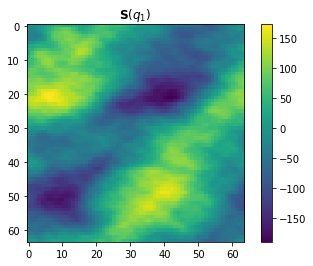

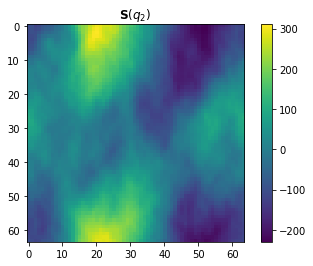

In [103]:
plt.title(r"${\bf S}(q_1)$")
plt.imshow(Sfield0.real);plt.colorbar();plt.show()
# plt.imshow(Sfield0.imag);plt.colorbar();plt.show()
plt.title(r"${\bf S}(q_2)$")
plt.imshow(Sfield1.real);plt.colorbar();plt.show()
# plt.imshow(Sfield1.imag);plt.colorbar();plt.show()

In [150]:
def momentum(a,da):
    """
    Calculate momentum of 10 particles at scale factor a
    Given a and stepsize da
    """
    
    anow = a-da/2
    znow = 1/anow - 1
    
    # momentum of all 64x64 particles
    ans = -1*anow**2 * analytical_deriv(znow)*Sfield # (64,64,2)
    
    # return only first 10
    return ans[0,:10,:]
    
    
    

In [151]:
# Initial positions, 64*64*2 array 
# containing x,y pos of all 64x64 particles
qvec = qvector(N)

# # First plot only first 16 particles
# plt.scatter(qvec[:4,:4,0],qvec[:4,:4,1],alpha=0.5)
# plt.show()

# a = 0.0025 is the initial timestep 
# We need at least 90 frames, so let's do 100
all_a = sr.linspace(0.0025,1,100)
da = all_a[1]-all_a[0]
# positions of first 10 particles along y direction
first_positions = np.zeros((len(all_a),10,2))
# momentum of first 10 particles along y direction
first_momenta = np.zeros((len(all_a),10,2))

for i, a in enumerate(all_a):
    xvec = qvec + growth_factor(a, Omega_m, Omega_Lamb)*Sfield
    # Make sure we have periodic boundary conditions
    xvec %= N
    
    # Save first 10 positions
    first_positions[i,:,:] = xvec[0,:10,:]
    # Save first 10 momenta
    if i>0:
        p = momentum(a, da)
        first_momenta[i,:] = p
    
    plt.title(f'a={a}')
    plt.scatter(xvec[:,:,0],xvec[:,:,1],alpha=0.5)
    plt.xlabel('Mpc')
    plt.ylabel('Mpc')
    plt.savefig(f'./plots/movie/4c_{i:04d}.png')
    plt.close()

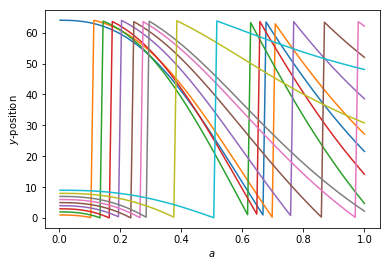

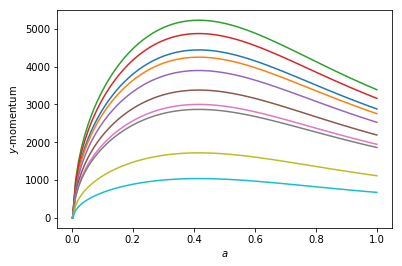

In [152]:
# Also plot the position and momentum of the first 10 particles
# along the y-direction vs a

# y-position
for i in range(10):
    plt.plot(all_a,first_positions[:,i,1]) # plot only y coordinate
    plt.ylabel('$y$-position')
    plt.xlabel('$a$')
plt.show()

# y-momentum
for i in range(10):
    plt.plot(all_a,first_momenta[:,i,1]) # plot only y coordinate
    plt.ylabel('$y$-momentum')
    plt.xlabel('$a$')
plt.show()



#### d) Generate initial conditions for a 3D box to do an N-body simulation, make initial conditions for $64^3$ particles starting at redshift 50. Besides this make 3 seperate movies of a slice of thickness 1/64th of your box at its center, make a slice for x-y, x-z and y-z. Again make a movie of at least 3 seconds with at least 30 frames per second. Remember: slice, not projection. Finally, plot the position and momentum of the first 10 particles along the z-direction vs a

In [ ]:
# Now we repeat basically the same thing, except we start at z=50
a = 1/51
